# Import Packages 

In [ ]:
# Force scikit version 1.2.2
!pip install scikit-learn==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Force joblib version 1.2.0
!pip install joblib==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretrainedmodels
!pip install mlxtend

import pretrainedmodels
import pretrainedmodels.utils as utils
import natsort
import os
import torch
import os.path
import joblib

import numpy as np
from sklearn import svm, metrics, linear_model, svm, neighbors, datasets, neural_network

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import glob
from matplotlib.pyplot import imshow
from os import listdir
from os.path import join

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from functools import partial

import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import EnsembleVoteClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=84f74be142286c7ee7408182f7f4ec52d0f4fbac2afdc14ac94d7fd042884f4f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Datasets

In [ ]:
# Function for loading datasets 
def read_dataset(path):
  image = []
  label = []

  for filename in glob.glob(path): #assuming jpg
      image.append(filename)
      label.append(int(filename[:-4][-1]))

  number_instances = len(image)

  images_list = list(image) # The array needs to be converted into a list to remove elements                                             
  images_list_np = np.array(images_list)

  # Shuffle the dataset randomly
  image, label = shuffle(image, label, random_state=42)

  # Count the occurance of healthy and loser fish
  print("loser fish:", label.count(0))
  print("healthy fish:", label.count(1))

  return image, label

loser fish: 306
healthy fish: 888


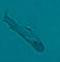

In [ ]:
# Load train dataset
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/train/images_cropped/*.jpg'
train_images, train_labels = read_dataset(path)

# Display train image
Image.open(train_images[0])

loser fish: 86
healthy fish: 260


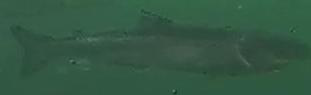

In [ ]:
# Load valid dataset
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/valid/images_cropped/*.jpg'
valid_images, valid_labels = read_dataset(path)

# Display valid image
Image.open(valid_images[0])

loser fish: 39
healthy fish: 171


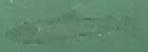

In [ ]:
# Load test dataset
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/test/images_cropped_manual/*.jpg'
test_images, test_labels = read_dataset(path)

# Display test image
Image.open(test_images[0])

# Extract Features

In [ ]:
def create_extraction_model():
    # load model
    model_name = 'resnet101' # CNN that is 101 layers deep. could be fbresnet152 or inceptionresnetv2  
    model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    model.eval()
    # select output layer (obtain the layer before the classification)
    model.last_linear = pretrainedmodels.utils.Identity()
    return model


In [ ]:
def extract_features(path_img, model = None):
    if model == None:
      model = create_extraction_model()
    
    torch.set_num_threads(4)

    # load image
    # transformations depending on the model
    # rescale, center crop, normalize, and others (ex: ToBGR, ToRange255)
    tf_img = utils.TransformImage(model)
    load_img = utils.LoadImage()
    input_img = load_img(path_img)
    input_tensor = tf_img(input_img) # 3x400x225 -> 3x299x299 size may differ
    input_tensor = input_tensor.unsqueeze(0) # 3x299x299 -> 1x3x299x299
    input = torch.autograd.Variable(input_tensor, requires_grad=False)

    # extract
    features = model(input) # obtain features
    features = features.data.cpu().numpy().tolist()[0]
    return features

In [ ]:
def check_extracted_features(feature, path, image):
  if os.path.isfile(path):
    # Load extracted features
    feature = np.load(path)

  else:
    # Extract features
    model = create_extraction_model()

    for filepath in tqdm(image):
      feature.append(extract_features(filepath, model = model))

    # Save extracted features
    np.save(path, feature)    # .npy extension is added if not given

  feature_matrix_list = list(feature) # the array needs to be converted into a list to remove elements  

  # Number of features 
  print("Number of features: ", len(feature))
  print("Number of features in list: ", len(feature_matrix_list))

  # Length of train feature 1
  print("Length of one feature:", len(feature[0]))

  return feature_matrix_list

In [ ]:
# Get training extract features
train_features = []
path = ('drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/train/train_features_unbalanced_1.2.2.npy')
train_feature_matrix_list = check_extracted_features(train_features, path, train_images)

Number of features:  1194
Number of features in list:  1194
Length of one feature: 2048


In [ ]:
# Get validation extract features
valid_features = []
path = ('drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/valid/valid_features_unbalanced_1.2.2.npy')
valid_feature_matrix_list = check_extracted_features(valid_features, path, valid_images)

Number of features:  346
Number of features in list:  346
Length of one feature: 2048


In [ ]:
# Get test extract features
test_features = []
path = ('drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/test/test_features_unbalanced_1.2.2.npy')
test_feature_matrix_list = check_extracted_features(test_features, path, test_images)

Number of features:  210
Number of features in list:  210
Length of one feature: 2048


# Principal Component Analysis

In [ ]:
# Function for finding principal components
def principal_component_analysis(feature_matrix_list):
  scaler = StandardScaler()
  scaler.fit(feature_matrix_list)
  feature_scaled = scaler.transform(feature_matrix_list)

  pca = PCA(n_components=100) #max 172
  pca.fit(feature_scaled)
  feature_scaled_pca = pca.transform(feature_scaled)
  print('Shape of features with scaling and PCA', np.shape(feature_scaled_pca))
  #print('Explained var: ')
  exp_var =pca.explained_variance_ratio_*100 
  #print(exp_var)  # for each feature
  total_var = pca.explained_variance_ratio_.sum() * 100
  print('Total_var = %0.3f' % total_var)
  cum_exp_var = np.cumsum(pca.explained_variance_ratio_ * 100)

  plt.figure()
  plt.plot(range(0,len(cum_exp_var)),cum_exp_var, label='Cumulative explained variance')
  plt.bar(range(0,len(exp_var)), exp_var, alpha=0.5, align='center', label='Individual explained variance')
  #plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal component index')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  # Percentage of variance explained
  labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']

  plt.figure()
  plt.bar(labels, exp_var[0:10])
  plt.xlabel('Pricipal Component')
  plt.ylabel('Proportion of Variance Explained')

  print('Variance explained with PC1 + PC2: %0.1f' %(exp_var[0] + exp_var[1]))

  #return feature_scaled_pca

Shape of features (1194, 2048)
Shape of features with scaling and PCA (1194, 100)
Total_var = 85.133


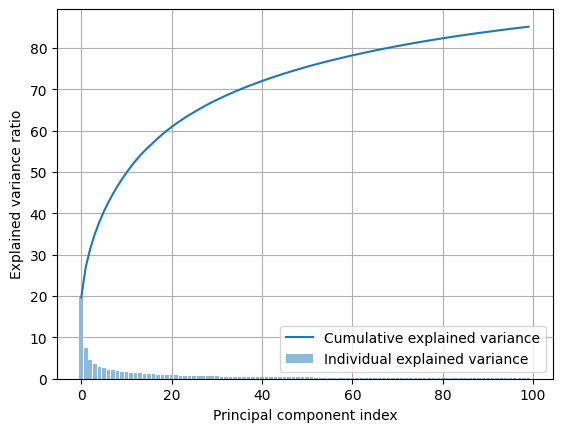

Variance explained with PC1 + PC2: 27.1


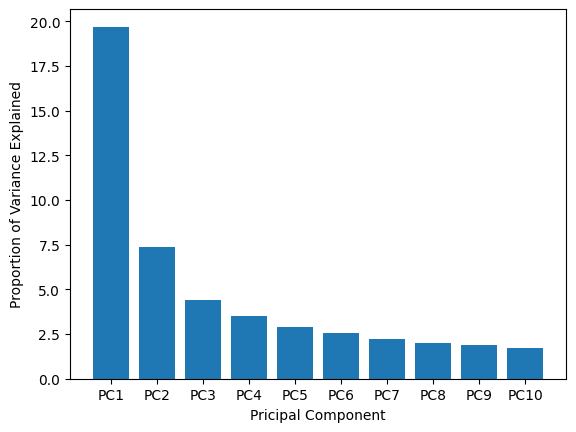

In [ ]:
# Feature engineering training
print('Shape of features', np.shape(train_feature_matrix_list))
train_feature_matrix_list_PCA = principal_component_analysis(train_feature_matrix_list)

Shape of features (346, 2048)
Shape of features with scaling and PCA (346, 100)
Total_var = 90.028


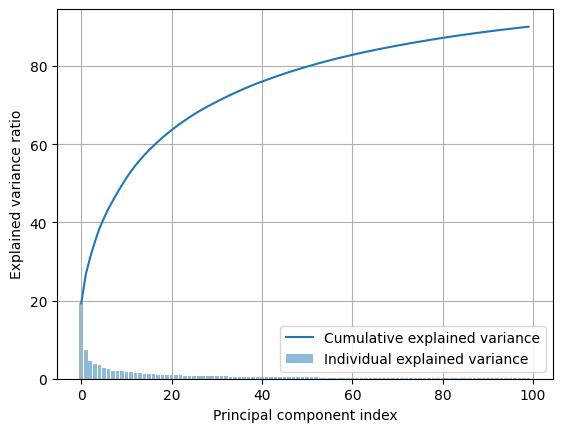

Variance explained with PC1 + PC2: 26.7


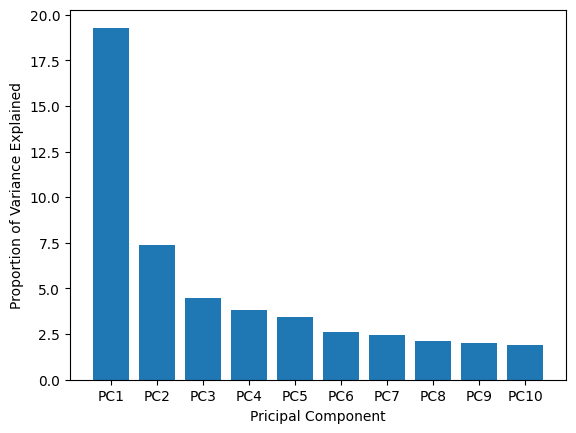

In [ ]:
# Feature engineering validation
print('Shape of features', np.shape(valid_feature_matrix_list))
valid_feature_matrix_list_PCA = principal_component_analysis(valid_feature_matrix_list)

# Pipelining

In [ ]:
# create pipelines
pca         = PCA(n_components=100, random_state=42)
percep      = linear_model.Perceptron(random_state=42)
adaline     = SGDClassifier(random_state=42)
svc         = SVC(probability=True, random_state=42)
neighbor    = neighbors.KNeighborsClassifier(n_neighbors=9)
mlp         = MLPClassifier(hidden_layer_sizes=(100), max_iter=200, random_state=42) #50,10, max_iter=1000   ###how big should hidden layer sizes be and max iterations? 100,50, 1000
standScaler = StandardScaler()
minmax      = MinMaxScaler()

pipe1 = Pipeline(steps = [('minmax', minmax), ('standScaler', standScaler), ('pca', pca), ('percep', percep)])  
pipe2 = Pipeline(steps = [('minmax', minmax), ('standScaler', standScaler), ('pca', pca), ('adaline', adaline)])
pipe3 = Pipeline(steps = [('minmax', minmax), ('standScaler', standScaler), ('pca', pca), ('svc', svc)])
pipe4 = Pipeline(steps = [('minmax', minmax), ('standScaler', standScaler), ('pca', pca), ('neighbor', neighbor)])
pipe5 = Pipeline(steps = [('minmax', minmax), ('standScaler', standScaler), ('pca', pca), ('mlp', mlp)])


In [ ]:
param_grid = {
              'pca__n_components': [50, 75, 100, 125],
    }

param_gridSVC = {
              'pca__n_components': [50, 75, 100, 125],
              'svc__C': [0.001, 0.01, 0.1, 1, 10],
              #'svc__gamma': [0.1, 0.01, 0.001, 0.0001],
              'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    }

param_gridKNN = {
              'pca__n_components': [50, 75, 100, 125],
              'neighbor__n_neighbors': [3, 5, 7, 9, 11],
    }

param_gridMLP = {
              'pca__n_components': [50, 75, 100, 125],
              'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
              'mlp__solver': ['lbfgs', 'sgd', 'adam'],
    } 

In [ ]:
positive_label = 0 # 0 for finding loser and 1 for finding healthy 
negative_label = 1 if positive_label == 0 else 0 # opposite of positive_label
gridSearch_results = "F1_loser" # choose between F1_loser or accuracy as scoring

In [ ]:
# grid search: exhaustive search over specified parameter values for an estimator
@ignore_warnings(category=ConvergenceWarning)

def gridSearchCV(pipe, param_grid):
  if gridSearch_results == "F1_loser": 
    my_partial_func = partial(metrics.f1_score, pos_label = positive_label)
    my_partial_func.__name__ = "F1_loser"
    grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring=metrics.make_scorer(my_partial_func), verbose=1) # Score by F1 score 
  else:
    grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)                                                    # Score by accuracy, both give same final results 
  grid_search.fit(train_feature_matrix_list, train_labels)
  score = grid_search.score(train_feature_matrix_list, train_labels)
  #print('Score for 5 fold CV : %0.3f' %(score))

  print(grid_search.best_estimator_)
  print()
  return grid_search

In [ ]:
#gridSearchCV(pipe1, param_grid)

In [ ]:
def check_learners(path, pipe, param):
  if os.path.isfile(path):
    # Load grid_search_cv learner
    learner = joblib.load(path)

  else:
    # Perform grid_search_cv for learner
    learner = gridSearchCV(pipe, param)

    # Save grid_search_cv learner
    joblib.dump(learner, path)

  print("Score:", learner.best_score_.round(3))
  print(learner.best_params_)
  print()
  print('training score: %0.3f' % learner.score(train_feature_matrix_list, train_labels))
  print('validation score: %0.3f' % learner.score(valid_feature_matrix_list, valid_labels)) 

  return learner

In [ ]:
# Get grid_search_cv results for perceptron
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/learner_1_unbalanced_' + gridSearch_results + '_1.2.2' + '.pkl'
learner_1 = check_learners(path, pipe1, param_grid)

Score: 0.772
{'pca__n_components': 100}

training score: 0.831
validation score: 0.790


In [ ]:
# Get grid_search_cv results for adaline
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/learner_2_unbalanced_' + gridSearch_results + '_1.2.2' + '.pkl'
learner_2 = check_learners(path, pipe2, param_grid)

Score: 0.768
{'pca__n_components': 100}

training score: 0.859
validation score: 0.756


In [ ]:
# Get grid_search_cv results for SVC
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/learner_3_unbalanced_' + gridSearch_results + '_1.2.2' + '.pkl'
learner_3 = check_learners(path, pipe3, param_gridSVC)

Score: 0.841
{'pca__n_components': 125, 'svc__C': 10, 'svc__kernel': 'rbf'}

training score: 0.997
validation score: 0.815


In [ ]:
# Get grid_search_cv results for KNN
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/learner_4_unbalanced_' + gridSearch_results + '_1.2.2' + '.pkl'
learner_4 = check_learners(path, pipe4, param_gridKNN)

Score: 0.724
{'neighbor__n_neighbors': 3, 'pca__n_components': 125}

training score: 0.858
validation score: 0.662


In [ ]:
# Get grid_search_cv results for MLP
path = 'drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/learner_5_unbalanced_' + gridSearch_results + '_1.2.2' + '.pkl' 
learner_5 = check_learners(path, pipe5, param_gridMLP)

Score: 0.819
{'mlp__activation': 'logistic', 'mlp__solver': 'adam', 'pca__n_components': 100}

training score: 0.998
validation score: 0.827


In [ ]:
# Get the base learner predictions
predictions_1 = learner_1.predict(valid_feature_matrix_list) #Perceptron
predictions_2 = learner_2.predict(valid_feature_matrix_list) #Adaline
predictions_3 = learner_3.predict(valid_feature_matrix_list) #SVC
predictions_4 = learner_4.predict(valid_feature_matrix_list) #KNeighborsClassifier
predictions_5 = learner_5.predict(valid_feature_matrix_list) #MLPClassifier

In [ ]:
# Accuracy of base learners
# how often is the classifier correct?
print('Perceptron Accuracy:   ', accuracy_score(valid_labels, predictions_1).round(3))
print('Adaline Accuracy:      ', accuracy_score(valid_labels, predictions_2).round(3))
print('SVC Accuracy:          ', accuracy_score(valid_labels, predictions_3).round(3))
print('KNN Accuracy:          ', accuracy_score(valid_labels, predictions_4).round(3))
print('MLP Accuracy:          ', accuracy_score(valid_labels, predictions_5).round(3))
print()

# Precision of base learners
# what percentage of positive tuples are labeled as such?
print("Perceptron Precision:  ", metrics.precision_score(valid_labels, predictions_1, pos_label = positive_label).round(3))
print("Adaline Precision:     ", metrics.precision_score(valid_labels, predictions_2, pos_label = positive_label).round(3))
print("SVC Precision:         ", metrics.precision_score(valid_labels, predictions_3, pos_label = positive_label).round(3))
print("KNN Precision:         ", metrics.precision_score(valid_labels, predictions_4, pos_label = positive_label).round(3))
print("MLP Precision:         ", metrics.precision_score(valid_labels, predictions_5, pos_label = positive_label).round(3))
print()

# Recall of base learners / sensitivity
# what percentage of positive tuples are labeled as such?
print("Perceptron Recall:     ", metrics.recall_score(valid_labels, predictions_1, pos_label = positive_label).round(3))
print("Adaline Recall:        ", metrics.recall_score(valid_labels, predictions_2, pos_label = positive_label).round(3))
print("SVC Recall:            ", metrics.recall_score(valid_labels, predictions_3, pos_label = positive_label).round(3))
print("KNN Recall:            ", metrics.recall_score(valid_labels, predictions_4, pos_label = positive_label).round(3))
print("MLP Recall:            ", metrics.recall_score(valid_labels, predictions_5, pos_label = positive_label).round(3))
print()

# Specificity of base learners 
# what percentage of negative tuples are labeled as such?
print("Perceptron Specificity:", metrics.recall_score(valid_labels, predictions_1, pos_label = negative_label).round(3)) 
print("Adaline Specificity:   ", metrics.recall_score(valid_labels, predictions_2, pos_label = negative_label).round(3)) 
print("SVC Specificity:       ", metrics.recall_score(valid_labels, predictions_3, pos_label = negative_label).round(3)) 
print("KNN Specificity:       ", metrics.recall_score(valid_labels, predictions_4, pos_label = negative_label).round(3)) 
print("MLP Specificity:       ", metrics.recall_score(valid_labels, predictions_5, pos_label = negative_label).round(3)) 
print()

# Calculate F1 score
print("Perceptron F1 score:   ", metrics.f1_score(valid_labels, predictions_1, pos_label = positive_label).round(3))
print("Adaline F1 score:      ", metrics.f1_score(valid_labels, predictions_2, pos_label = positive_label).round(3))
print("SVC F1 score:          ", metrics.f1_score(valid_labels, predictions_3, pos_label = positive_label).round(3))
print("KNN F1 score:          ", metrics.f1_score(valid_labels, predictions_4, pos_label = positive_label).round(3))
print("MLP F1 score:          ", metrics.f1_score(valid_labels, predictions_5, pos_label = positive_label).round(3))

Perceptron Accuracy:    0.902
Adaline Accuracy:       0.884
SVC Accuracy:           0.916
KNN Accuracy:           0.858
MLP Accuracy:           0.919

Perceptron Precision:   0.842
Adaline Precision:      0.795
SVC Precision:          0.901
KNN Precision:          0.814
MLP Precision:          0.882

Perceptron Recall:      0.744
Adaline Recall:         0.721
SVC Recall:             0.744
KNN Recall:             0.558
MLP Recall:             0.779

Perceptron Specificity: 0.954
Adaline Specificity:    0.938
SVC Specificity:        0.973
KNN Specificity:        0.958
MLP Specificity:        0.965

Perceptron F1 score:    0.79
Adaline F1 score:       0.756
SVC F1 score:           0.815
KNN F1 score:           0.662
MLP F1 score:           0.827


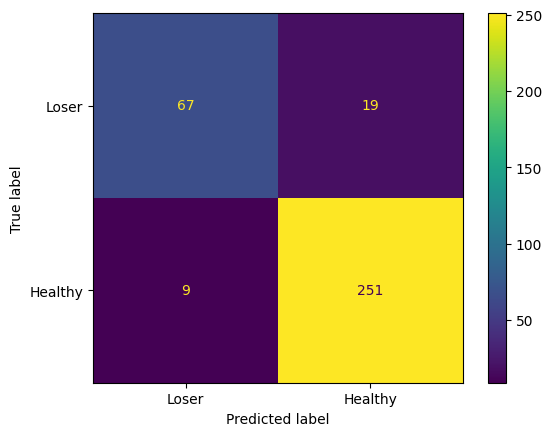

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_labels, predictions_5, labels=learner_5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loser", "Healthy"])
disp.plot()

plt.show()

In [ ]:
# Classification report
print(classification_report(valid_labels, predictions_5))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83        86
           1       0.93      0.97      0.95       260

    accuracy                           0.92       346
   macro avg       0.91      0.87      0.89       346
weighted avg       0.92      0.92      0.92       346



#Variance of Classifiers

In [ ]:
def classification_correlation(samples1, samples2): # Sample correlation coefficient formula
  n = len(samples1)
  assert n == len(samples2)              
  mu1 = sum(samples1)/n #average 
  mu2 = sum(samples2)/n
  numer = sum((s1 - mu1) * (s2 - mu2) for s1, s2 in zip(samples1, samples2))
  denomSq1 = sum((s - mu1) ** 2 for s in samples1)
  denomSq2 = sum((s - mu2) ** 2 for s in samples2)
  return numer / np.sqrt(denomSq1 * denomSq2)

In [ ]:
classification_correlation([1, 0, 0, 1], [0, 1, 1, 0])

-1.0

In [ ]:
def visualize_learner_correlation(guess_or_correctness = "guess"):
  preds = []
  preds.append(learner_1.predict(valid_feature_matrix_list))
  preds.append(learner_2.predict(valid_feature_matrix_list))
  preds.append(learner_3.predict(valid_feature_matrix_list))
  preds.append(learner_4.predict(valid_feature_matrix_list))
  preds.append(learner_5.predict(valid_feature_matrix_list))

  if guess_or_correctness == "guess":
    corrs = np.array([np.array([classification_correlation(p1, p2) for p1 in preds]) for p2 in preds])
  elif guess_or_correctness == "correctness":
    correctness = []
    for pred in preds:
      correctness.append(list((1 if p == c else 0) for p, c in zip(pred, valid_labels) ))

    corrs = np.array([np.array([classification_correlation(p1, p2) for p1 in correctness]) for p2 in correctness])
  else:
    raise ValueError("Don't know what to display:", guess_or_correctness)

  fig, ax = plt.subplots()

  intersection_matrix = corrs

  ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

  ax.set_xticklabels(range(0, 6))
  ax.set_yticklabels(range(0, 6))

  for i in range(5):
      for j in range(5):
          c = intersection_matrix[j,i]
          ax.text(i, j, str(c.round(3)), va='center', ha='center')
  plt.show()

<ipython-input-70-a9ad383f410c>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0, 6))
<ipython-input-70-a9ad383f410c>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0, 6))


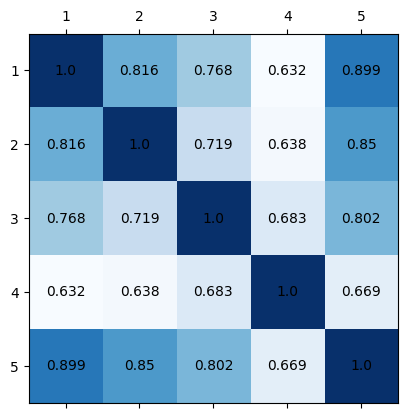

In [ ]:
#correlation of the classifiers guess
visualize_learner_correlation("guess")

<ipython-input-43-a9ad383f410c>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0, 6))
<ipython-input-43-a9ad383f410c>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0, 6))


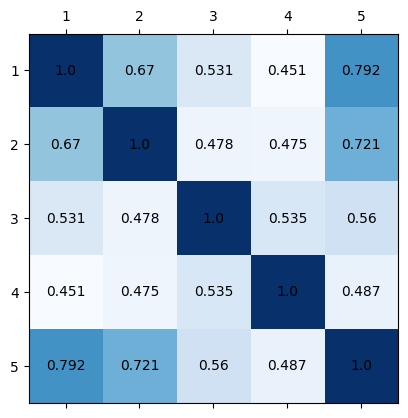

In [ ]:
#correlation of whether the classifiers are correct
visualize_learner_correlation("correctness")

In [ ]:
def learner_pairs():
  preds = []
  preds.append(learner_1.predict(valid_feature_matrix_list))
  preds.append(learner_2.predict(valid_feature_matrix_list))
  preds.append(learner_3.predict(valid_feature_matrix_list))
  preds.append(learner_4.predict(valid_feature_matrix_list))
  preds.append(learner_5.predict(valid_feature_matrix_list))

  xs = []
  ys = []
  labs = []

  for voter1 in range(5):
    for voter2 in range(5):
      if voter1 <= voter2:
        continue
      v1g = preds[voter1]
      v2g = preds[voter2]
      #comb_preds = [1- (1 - g1) * (1 - g2) for g1, g2 in zip(v1g, v2g)] #F1 for loser fish using hard voting (if one says loser, the guess is loser)
      #f1 = metrics.f1_score(valid_labels, comb_preds, pos_label = positive_label)
      f1v1 = metrics.f1_score(valid_labels, v1g, pos_label = positive_label)
      f1v2 = metrics.f1_score(valid_labels, v2g, pos_label = positive_label)
      corr = classification_correlation(v1g, v2g)
      xs.append(corr)
      #ys.append(f1)
      ys.append((f1v1 + f1v2)/2)
      #ys.append(np.sqrt(f1v1 * f1v2))
      labs.append(str((voter1 + 1, voter2 + 1)))

  fig, ax = plt.subplots()
  ax.scatter(xs, ys)

  for i, txt in enumerate(labs):
    ax.annotate(txt, (xs[i] - 0.02, ys[i] - 0.04))
  
  plt.axis([0.5, 1, 0.5, 1])
  plt.xlabel("Correlation")
  plt.ylabel("F1 score average")                                                  
  plt.grid()
  plt.show()

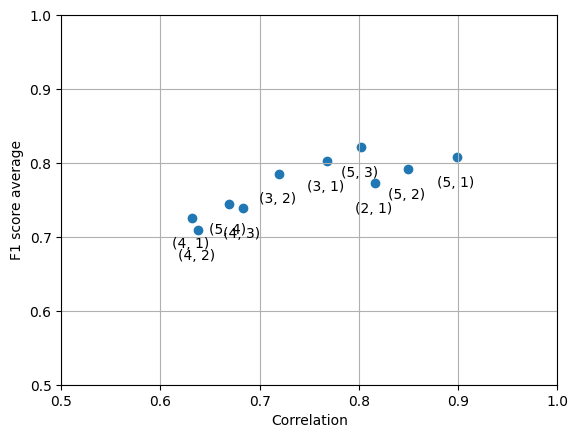

In [ ]:
#F1 score regarding correlation of two classifiers
learner_pairs()

In [ ]:
def visualize_learner_correctness():
  preds = []
  preds.append(learner_1.predict(valid_feature_matrix_list))
  preds.append(learner_2.predict(valid_feature_matrix_list))
  preds.append(learner_3.predict(valid_feature_matrix_list))
  preds.append(learner_4.predict(valid_feature_matrix_list))
  preds.append(learner_5.predict(valid_feature_matrix_list))
  correct = np.array(valid_labels)

  amt_images = len(valid_feature_matrix_list)

  print("Each column is an image. 🔴 indicates incorrect prediction.")
  
  strs = ["", "", "", "", ""]
  
  amt_incorrect = [0] * amt_images
  
  for n in range(5):
    for i in range(amt_images):
      is_incorrect = preds[n][i] != correct[i]
      strs[n] += "🔴" if is_incorrect else "🟢" 
      amt_incorrect[i] += 1 if is_incorrect else 0

  # 🔵🟡⚪⚫🟠🟣🟤⭕🔴🟢 #unicode
  # ⒽⓁ

  corr_str = "".join("⚪" if correct[i] == 1 else "🟡" for i in range(amt_images))

  images_per_row = 44

  for i in range(0, amt_images, images_per_row):
    print("         " + corr_str[i:i + images_per_row])
    for n in range(5):
      print("learner" + str(n + 1) + ":" + strs[n][i:i + images_per_row])
    print("\n")

  print("\n\n")

  #5 incorrect classifiers
  for i in range(amt_images):
    if amt_incorrect[i] == 5:
      print("This is wrongly classified by all 5 classifiers: (it is labeled as " + ("healthy" if correct[i] == 1 else "loser") + " in the dataset)" )
      display(Image.open(valid_images[i]))

  #print("\n\n")

  # 4 incorrect clasifiers
  #for i in range(amt_images):
  #  if amt_incorrect[i] == 4:
  #    print("This is wrongly classified by 4 classifiers: (it is labeled as " + ("healthy" if correct[i] == 1 else "loser") + " in the dataset)" )
  #    display(Image.open(valid_images[i]))

  #print("\n\n")

  # 1 incorrect classifier
  #for i in range(amt_images):
  #  if amt_incorrect[i] == 1:
  #    print("This is wrongly classified by 1 classifier: (it is labeled as " + ("healthy" if correct[i] == 1 else "loser") + " in the dataset)" )
  #    display(Image.open(valid_images[i]))

  #print("\n\n")

  # 0 incorrect classifiers
  #for i in range(amt_images):
  #  if amt_incorrect[i] == 0:
  #    print("This is wrongly classified by 0 classifiers: (it is labeled as " + ("healthy" if correct[i] == 1 else "loser") + " in the dataset)" )
  #    display(Image.open(valid_images[i]))

Each column is an image. 🔴 indicates incorrect prediction.
         🟡⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪⚪🟡⚪⚪🟡⚪⚪⚪⚪⚪⚪🟡⚪🟡⚪⚪⚪⚪⚪🟡⚪⚪
learner1:🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🔴🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢
learner2:🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🔴🟢🟢🟢🔴🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
learner3:🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴
learner4:🔴🟢🟢🟢🟢🟢🟢🔴🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢
learner5:🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢


         🟡🟡⚪⚪🟡⚪🟡⚪⚪⚪⚪🟡⚪⚪⚪⚪⚪🟡⚪🟡🟡⚪⚪🟡⚪⚪⚪🟡⚪⚪⚪⚪🟡🟡⚪⚪⚪⚪⚪⚪🟡🟡🟡🟡
learner1:🟢🔴🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🔴🟢🔴
learner2:🟢🔴🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🔴🟢🔴
learner3:🟢🔴🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🔴🟢🔴
learner4:🔴🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🔴🟢🟢🔴🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🔴🔴🔴
learner5:🟢🔴🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🔴🟢🔴


         ⚪⚪⚪⚪⚪⚪🟡⚪⚪⚪⚪🟡🟡🟡⚪🟡⚪⚪🟡⚪🟡⚪🟡⚪⚪⚪⚪⚪🟡🟡⚪⚪⚪⚪🟡⚪⚪⚪🟡🟡⚪🟡⚪⚪
learner1:🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢
learner2:🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🟢
learner3:🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🔴🟢🟢🟢🟢🟢🔴🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢
learner4:🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🔴🟢🟢🟢🟢🟢🟢🟢🟢🔴🟢🟢🟢🟢🔴🟢🟢🟢🟢🟢🟢🔴🟢🟢
learner5:🔴🟢🟢🟢🟢🟢🟢🟢🟢🟢

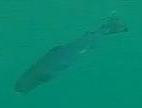

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


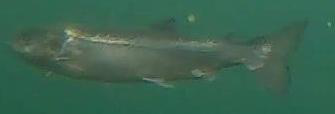

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


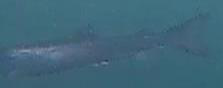

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


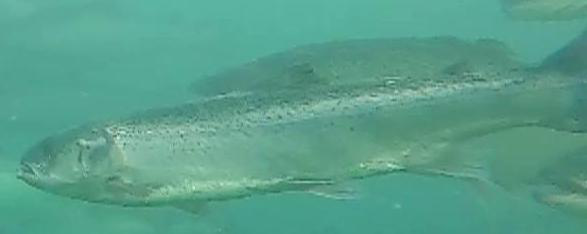

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


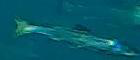

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


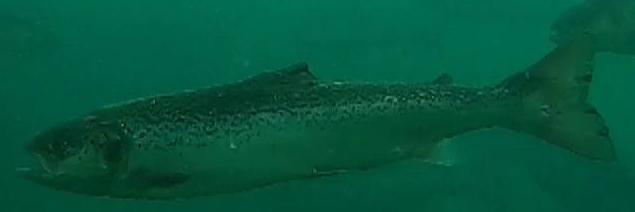

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


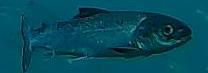

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


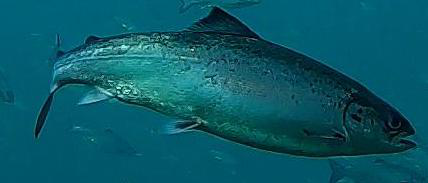

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


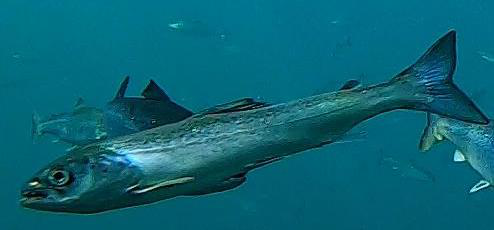

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


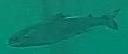

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


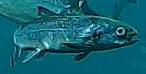

This is wrongly classified by all 5 classifiers: (it is labeled as healthy in the dataset)


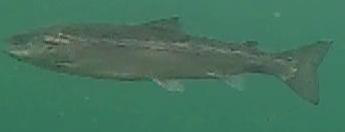

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


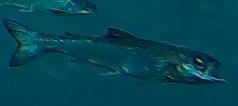

This is wrongly classified by all 5 classifiers: (it is labeled as loser in the dataset)


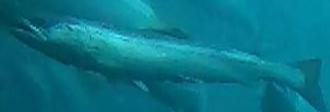

In [ ]:
visualize_learner_correctness()

Predicted class:  [1]
Actual class:  1


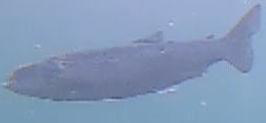

In [ ]:
# Spot check for some images
image_number = 19

print("Predicted class: ", learner_5.predict(np.array(valid_feature_matrix_list[image_number]).reshape(1, -1)))
print("Actual class: ", valid_labels[image_number])

Image.open(valid_images[image_number])

#Voting Ensemble

In [ ]:
def find_best_F1_score_voting(possible_weights, vote_type, increasing_best_weights = 10):
  predictions = []
  if vote_type == "hard":
    learners = [learner_1, learner_2, learner_3, learner_4, learner_5]
    predictions.append(learner_1.predict(valid_feature_matrix_list))
    predictions.append(learner_2.predict(valid_feature_matrix_list))
    predictions.append(learner_3.predict(valid_feature_matrix_list))
    predictions.append(learner_4.predict(valid_feature_matrix_list))
    predictions.append(learner_5.predict(valid_feature_matrix_list))
  else:
    learners = [learner_3, learner_4, learner_5]
    predictions.append(learner_3.predict_proba(valid_feature_matrix_list)[:,1])
    predictions.append(learner_4.predict_proba(valid_feature_matrix_list)[:,1])
    predictions.append(learner_5.predict_proba(valid_feature_matrix_list)[:,1])

  best_F1_score = 0 
  best_weights = ""
  best_predicted_class = None

  increasing_better_weights = [""] * increasing_best_weights
  increasing_better_weights_score = [metrics.f1_score([0], [1], pos_label = positive_label)] * increasing_best_weights

  for weights in possible_weights:
    wsums = sum(weights)
    preds = 0
    for w, pred in zip(weights, predictions):
      preds += w * pred
    predicted_class = [(1 if 2 * p > wsums else 0) for p in list(preds)]
    score = metrics.f1_score(valid_labels, predicted_class, pos_label = positive_label)
    best_predicted_class = predicted_class
    if score > best_F1_score:
      best_F1_score = score
      best_weights = weights
      increasing_better_weights = [best_weights] + increasing_better_weights[:-1]
      increasing_better_weights_score = [best_F1_score] + increasing_better_weights_score[:-1]

  voting = EnsembleVoteClassifier(learners, weights=best_weights, voting=vote_type, refit = False)

  # Fit classifier with the training data
  voting.fit(train_feature_matrix_list, train_labels)

  # Predict the most voted class (most probable class)
  voting_predictions = voting.predict(valid_feature_matrix_list)

  # Evaluate the models
  print('-'*30)
  print("Accuracy:          ", accuracy_score(valid_labels, voting_predictions).round(3))
  print("Precision:         ", metrics.precision_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))
  print("Recall:            ", metrics.recall_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))
  print("Specificity:       ", metrics.recall_score(valid_labels, voting_predictions, pos_label = negative_label).round(3)) 

  #print("Predicted F1 score:", best_F1_score.round(3))                                      
  print("Best F1 score:     ", metrics.f1_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))         
  print("Increasingly better weights:", increasing_better_weights)
  print("Increasingly better weights score:", [s.round(3) for s in increasing_better_weights_score])
  print("Best weights:", best_weights)

  cm = confusion_matrix(valid_labels, voting.predict(valid_feature_matrix_list)) #cmap=plt.cm.Blues
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loser", "Healthy"])
  disp.plot()

  return voting

In [ ]:
def generate_weight_list(vote_type, max_weight = 5):
  weights_list = []
  for v1 in range(0, max_weight + 1):
    for v2 in range(0, max_weight + 1):
      for v3 in range(0, max_weight + 1):
        if vote_type == "hard":
          for v4 in range(0, max_weight + 1):
            for v5 in range(0, max_weight + 1):
              if v1 + v2 + v3 + v4 + v5 == 0:
                continue

              weights_list.append([v1, v2, v3, v4, v5])
        else:
          if v1 + v2 + v3 == 0:
            continue
        
          weights_list.append([v1, v2, v3])

  return weights_list

<timed exec>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7775 [00:00<?, ?it/s]

------------------------------
Accuracy:           0.928
Precision:          0.877
Recall:             0.826
Specificity:        0.962
Best F1 score:      0.85
Increasingly better weights: [[1, 0, 2, 0, 1], [1, 0, 1, 1, 2], [0, 0, 1, 0, 1], [0, 0, 0, 0, 1], '', '', '', '', '', '']
Increasingly better weights score: [0.85, 0.843, 0.842, 0.827, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best weights: [1, 0, 2, 0, 1]
CPU times: user 13.4 s, sys: 404 ms, total: 13.8 s
Wall time: 14.7 s


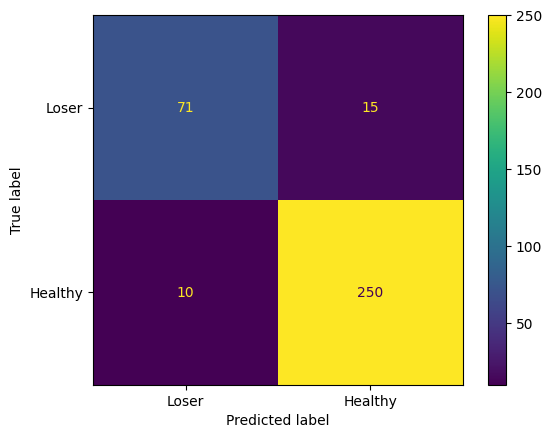

In [ ]:
%%time
best_hard_classifier = find_best_F1_score_voting(tqdm(generate_weight_list("hard")), "hard")

<timed exec>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/215 [00:00<?, ?it/s]

------------------------------
Accuracy:           0.922
Precision:          0.883
Recall:             0.791
Specificity:        0.965
Best F1 score:      0.834
Increasingly better weights: [[1, 0, 4], [1, 0, 1], [0, 0, 1], '', '', '', '', '', '', '']
Increasingly better weights score: [0.834, 0.83, 0.827, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best weights: [1, 0, 4]
CPU times: user 782 ms, sys: 203 ms, total: 984 ms
Wall time: 1 s


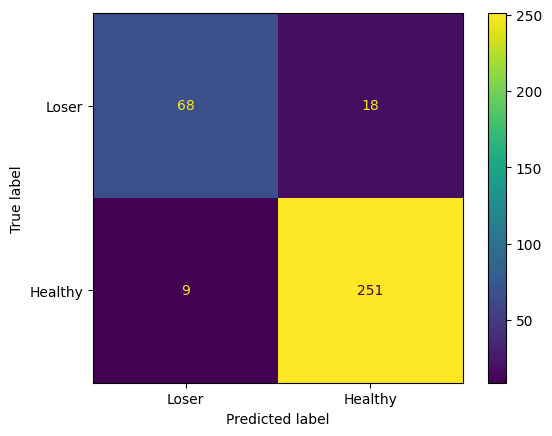

In [ ]:
%%time
best_soft_classifier = find_best_F1_score_voting(tqdm(generate_weight_list("soft")), "soft")

#Bootstrap Aggregation

In [ ]:
def aggregation(method):                                                        
  estimator_range = [20,40,60,80,100,120,140,160,180,200,220,240,260]
  learners = [('percep', learner_1), ('adaline', learner_2), ('svc', learner_3), ('neighbor', learner_4), ('mlp', learner_5)]

  models = []
  scores = []
  best_estimator = [0, 0]

  for n_estimators in tqdm(estimator_range):

      # Create classifier
      if method == GradientBoostingClassifier:
        final_estimator = method(n_estimators = n_estimators, subsample=0.5, min_samples_leaf=25, max_features=1, random_state=42)
        clf = StackingClassifier(estimators=learners, final_estimator=final_estimator, cv="prefit")

      else:
        final_estimator = method(random_state=42)
        clf = StackingClassifier(estimators=learners, final_estimator=final_estimator, cv="prefit")

      # Fit the model
      clf.fit(train_feature_matrix_list, train_labels)

      # Append the model and score to their respective list
      models.append(clf)
      score = metrics.f1_score(y_true = valid_labels, y_pred = clf.predict(valid_feature_matrix_list), pos_label = positive_label).round(3)
      scores.append(score)

      if score > best_estimator[1]:
        best_estimator[0] = int(n_estimators)
        best_estimator[1] = score   

  #print(scores)
  print(best_estimator)

  # Generate the plot of scores against number of estimators
  plt.figure(figsize=(9,6))
  plt.plot(estimator_range, scores)

  # Adjust labels and font (to make visable)
  plt.xlabel("Number of estimators", fontsize = 18)
  plt.ylabel("F1 score", fontsize = 18)
  plt.tick_params(labelsize = 16)

  # Visualize plot
  plt.show()                                                                                           

  # Predict the most voted class (most probable class)
  voting_predictions = clf.predict(valid_feature_matrix_list)

  # Evaluate the models
  print('-'*30)
  print("Accuracy:          ", accuracy_score(valid_labels, voting_predictions).round(3))
  print("Precision:         ", metrics.precision_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))
  print("Recall:            ", metrics.recall_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))
  print("Specificity:       ", metrics.recall_score(valid_labels, voting_predictions, pos_label = negative_label).round(3)) 

  #print("Predicted F1 score:", best_F1_score.round(3))                                      
  print("Best F1 score:     ", metrics.f1_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))         

  cm = confusion_matrix(valid_labels, voting_predictions) #cmap=plt.cm.Blues
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loser", "Healthy"])
  disp.plot()

  return clf

<ipython-input-62-e6552c952737>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_estimators in tqdm(estimator_range):


  0%|          | 0/13 [00:00<?, ?it/s]

[20, 0.815]


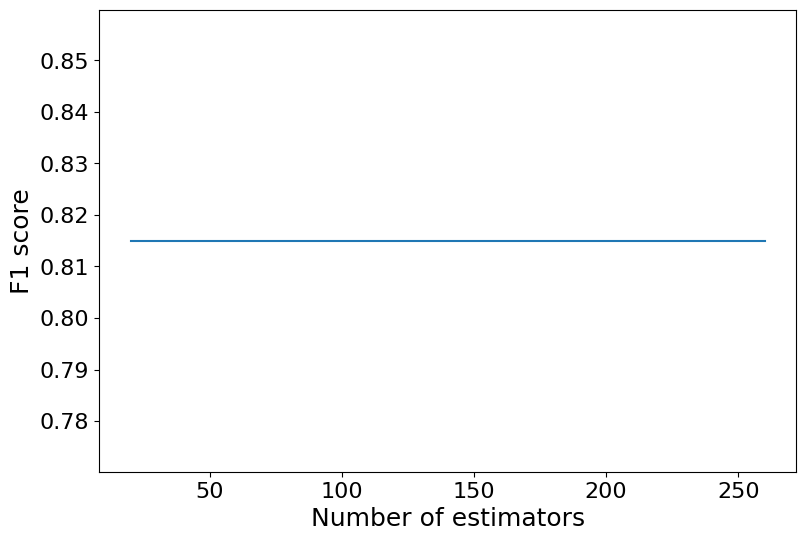

------------------------------
Accuracy:           0.916
Precision:          0.901
Recall:             0.744
Specificity:        0.973
Best F1 score:      0.815
CPU times: user 6.97 s, sys: 3.58 s, total: 10.6 s
Wall time: 7 s


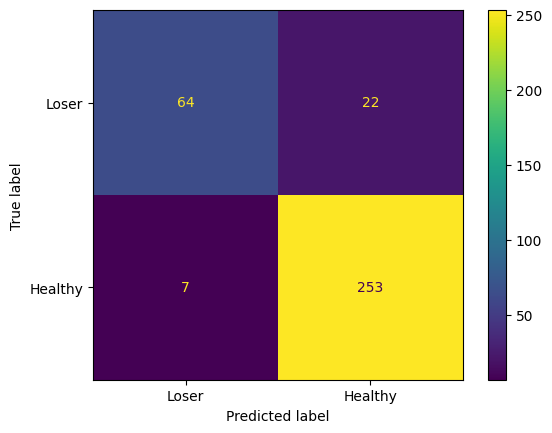

In [ ]:
%%time
logistic_regression = aggregation(LogisticRegression)

<ipython-input-62-e6552c952737>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_estimators in tqdm(estimator_range):


  0%|          | 0/13 [00:00<?, ?it/s]

[40, 0.825]


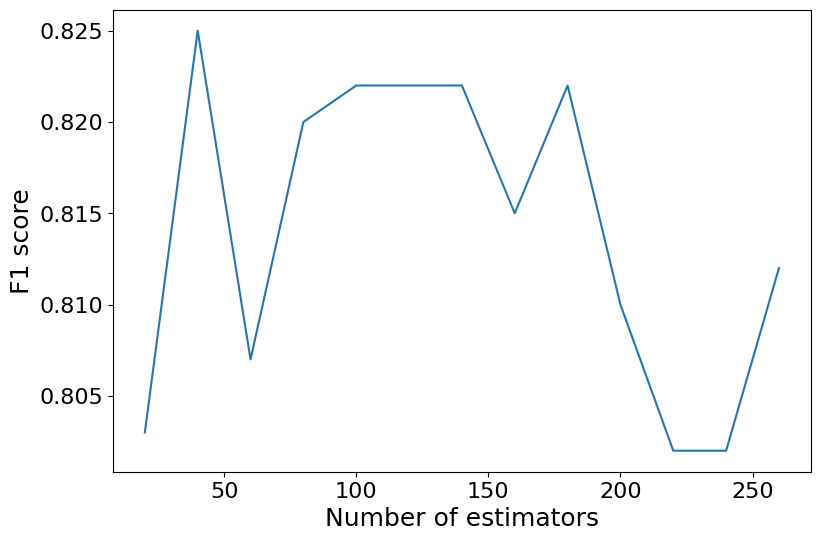

------------------------------
Accuracy:           0.913
Precision:          0.878
Recall:             0.756
Specificity:        0.965
Best F1 score:      0.812
CPU times: user 8.87 s, sys: 4.42 s, total: 13.3 s
Wall time: 8.69 s


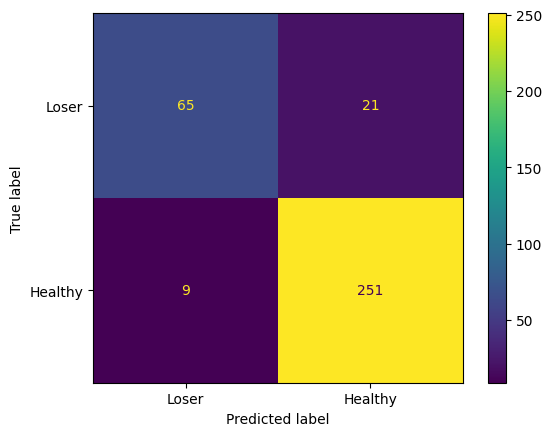

In [ ]:
%%time
boosting_classifier = aggregation(GradientBoostingClassifier)

In [ ]:
boosting_classifier

StackingClassifier(cv='prefit',
                   estimators=[('percep',
                                GridSearchCV(cv=5,
                                             estimator=Pipeline(steps=[('minmax',
                                                                        MinMaxScaler()),
                                                                       ('standScaler',
                                                                        StandardScaler()),
                                                                       ('pca',
                                                                        PCA(n_components=100,
                                                                            random_state=42)),
                                                                       ('percep',
                                                                        Perceptron(random_state=42))]),
                                             param_grid={'pca__n_components': [50,
                                                                               75,
                                                                               100,
                                                                               125]},
                                             scoring=make_scorer(F1_loser),
                                             verbose=1)),
                               ('adaline',
                                GridS...
                                                                        MLPClassifier(hidden_layer_sizes=100,
                                                                                      random_state=42))]),
                                             param_grid={'mlp__activation': ['identity',
                                                                             'logistic',
                                                                             'tanh',
                                                                             'relu'],
                                                         'mlp__solver': ['lbfgs',
                                                                         'sgd',
                                                                         'adam'],
                                                         'pca__n_components': [50,
                                                                               75,
                                                                               100,
                                                                               125]},
                                             scoring=make_scorer(F1_loser),
                                             verbose=1))],
                   final_estimator=GradientBoostingClassifier(max_features=1,
                                                              min_samples_leaf=25,
                                                              n_estimators=260,
                                                              random_state=42,
                                                              subsample=0.5))

In [ ]:
learner_2

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                       ('standScaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=100, random_state=42)),
                                       ('adaline',
                                        SGDClassifier(random_state=42))]),
             param_grid={'pca__n_components': [50, 75, 100, 125]},
             scoring=make_scorer(F1_loser), verbose=1)

In [ ]:
#%%time
#aggregation(BaggingClassifier)                                                #does not use the learners

In [ ]:
#%%time
#aggregation(RandomForestClassifier)                                           #does not use the learners

# Test and Evaluation

In [ ]:
test_predictions_hard = best_hard_classifier.predict(test_feature_matrix_list) 

In [ ]:
# Evaluate the models
print('-'*30)
print("Accuracy:          ", accuracy_score(test_labels, test_predictions_hard).round(3))
print("Precision:         ", metrics.precision_score(test_labels, test_predictions_hard, pos_label = positive_label).round(3))
print("Recall:            ", metrics.recall_score(test_labels, test_predictions_hard, pos_label = positive_label).round(3))
print("Specificity:       ", metrics.recall_score(test_labels, test_predictions_hard, pos_label = negative_label).round(3))                                       
print("Best F1 score:     ", metrics.f1_score(test_labels, test_predictions_hard, pos_label = positive_label).round(3)) 

------------------------------
Accuracy:           0.929
Precision:          0.8
Recall:             0.821
Specificity:        0.953
Best F1 score:      0.81


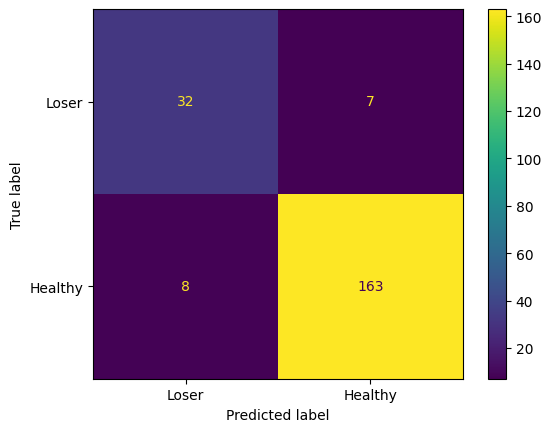

In [ ]:
cm = confusion_matrix(test_labels, test_predictions_hard, labels=best_hard_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loser", "Healthy"])
disp.plot()

plt.show()

This is classified wrong:  (it is labeled as loser in the dataset)


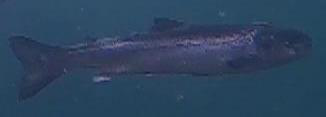

This is classified wrong:  (it is labeled as healthy in the dataset)


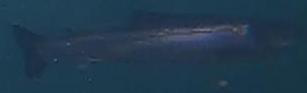

This is classified wrong:  (it is labeled as loser in the dataset)


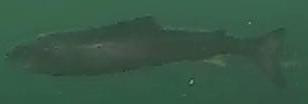

This is classified wrong:  (it is labeled as healthy in the dataset)


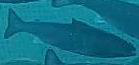

This is classified wrong:  (it is labeled as healthy in the dataset)


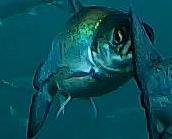

This is classified wrong:  (it is labeled as loser in the dataset)


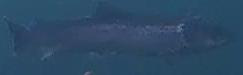

This is classified wrong:  (it is labeled as loser in the dataset)


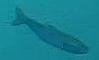

This is classified wrong:  (it is labeled as healthy in the dataset)


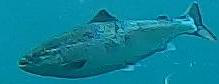

This is classified wrong:  (it is labeled as loser in the dataset)


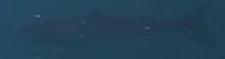

This is classified wrong:  (it is labeled as healthy in the dataset)


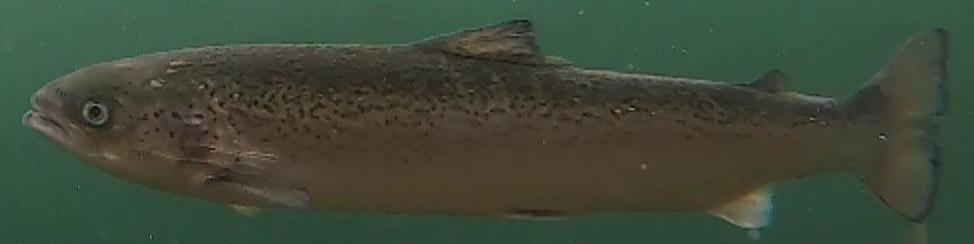

This is classified wrong:  (it is labeled as healthy in the dataset)


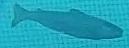

This is classified wrong:  (it is labeled as healthy in the dataset)


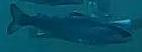

This is classified wrong:  (it is labeled as loser in the dataset)


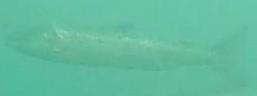

This is classified wrong:  (it is labeled as healthy in the dataset)


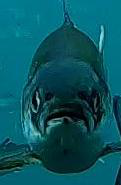

This is classified wrong:  (it is labeled as loser in the dataset)


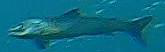

In [ ]:
#display fish classified wrong
for img, label, prediction in zip(test_images, test_labels, test_predictions_hard):
  if label != prediction:
    print("This is classified wrong: ", "(it is labeled as " + ("healthy" if label == 1 else "loser") + " in the dataset)")
    display(Image.open(img))

# Counting

In [ ]:
#import the cropped fish images from sea cages
image_paths = glob.glob('drive/MyDrive/Colab Notebooks/Master Thesis/Dataset_large/test/images_cropped/*.jpg')

In [ ]:
#function for extracting features from cropped fish images
def features_from_paths(paths_to_images):
  features = []
  model = create_extraction_model()
  for image_path in tqdm(paths_to_images):
    features.append(extract_features(image_path, model))
  return np.array(features)

In [ ]:
def predict_loser_count(feature_matrices):
  # Shuffle the dataset randomly
  feature_matrices_shuffled = shuffle(feature_matrices, random_state=42)

  result = best_hard_classifier.predict(feature_matrices_shuffled)
  
  number_of_loser_fish = len([() for label in result if label == 0]) # 0 is loser

  return number_of_loser_fish

In [ ]:
new_features = features_from_paths(image_paths)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-78-bb8cd1e14a9d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_path in tqdm(paths_to_images):


  0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
#train data
print("Predicted number of images of loser fish:", predict_loser_count(train_feature_matrix_list), "of", len(train_feature_matrix_list))

Predicted number of images of loser fish: 306 of 1194


In [ ]:
#test data
#predict how many of the cropped images are of loser fish 
print("Predicted number of images of loser fish:", predict_loser_count(new_features), "of", len(new_features))

Predicted number of images of loser fish: 73 of 196


This is counted as a loser fish


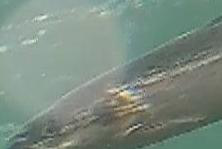

This is counted as a loser fish


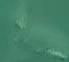

This is counted as a loser fish


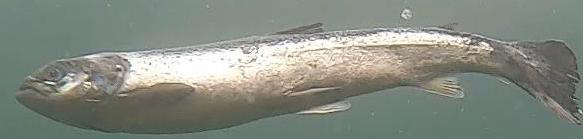

This is counted as a loser fish


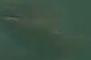

This is counted as a loser fish


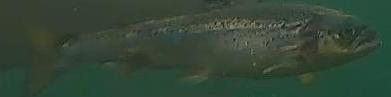

This is counted as a loser fish


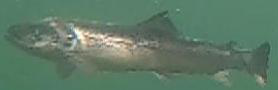

This is counted as a loser fish


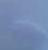

This is counted as a loser fish


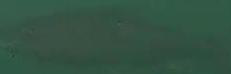

This is counted as a loser fish


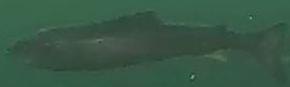

This is counted as a loser fish


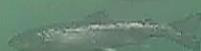

This is counted as a loser fish


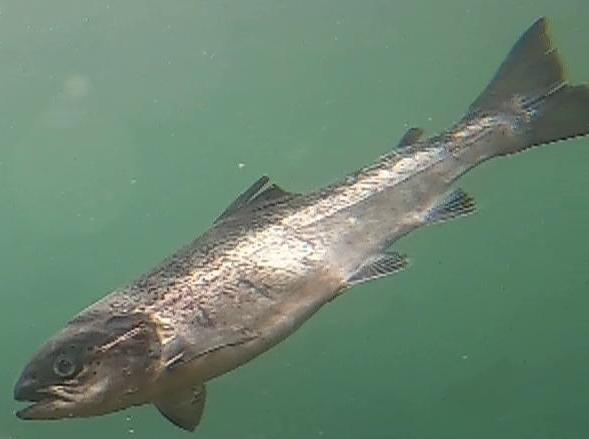

This is counted as a loser fish


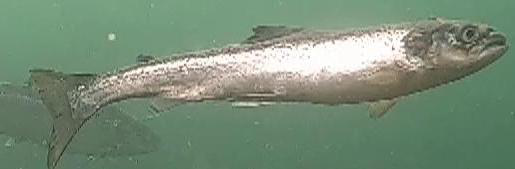

This is counted as a loser fish


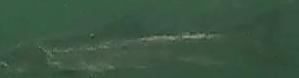

This is counted as a loser fish


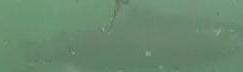

This is counted as a loser fish


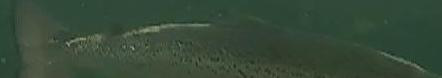

This is counted as a loser fish


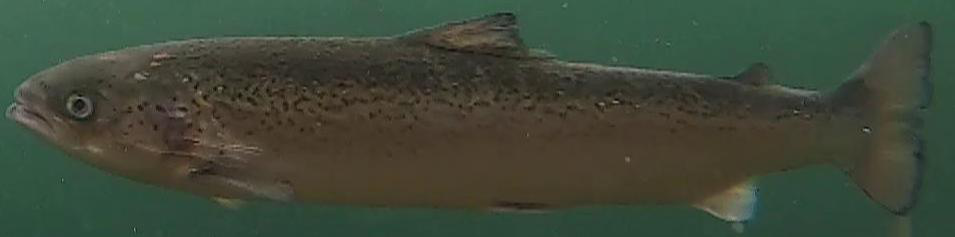

This is counted as a loser fish


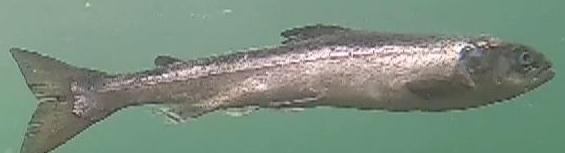

This is counted as a loser fish


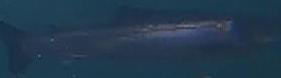

This is counted as a loser fish


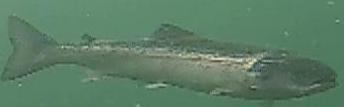

This is counted as a loser fish


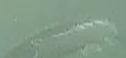

This is counted as a loser fish


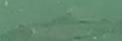

This is counted as a loser fish


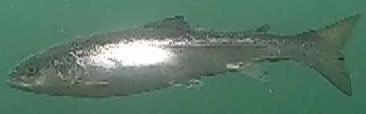

This is counted as a loser fish


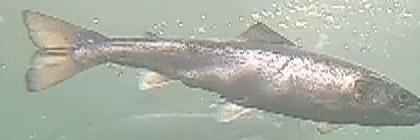

This is counted as a loser fish


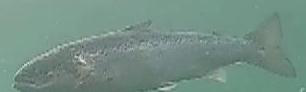

This is counted as a loser fish


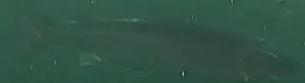

This is counted as a loser fish


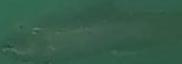

This is counted as a loser fish


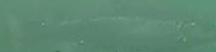

This is counted as a loser fish


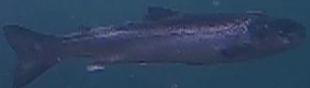

This is counted as a loser fish


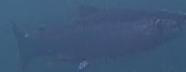

This is counted as a loser fish


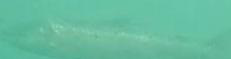

This is counted as a loser fish


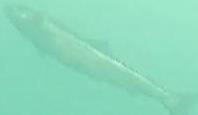

This is counted as a loser fish


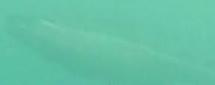

This is counted as a loser fish


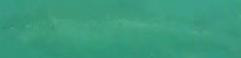

This is counted as a loser fish


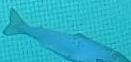

This is counted as a loser fish


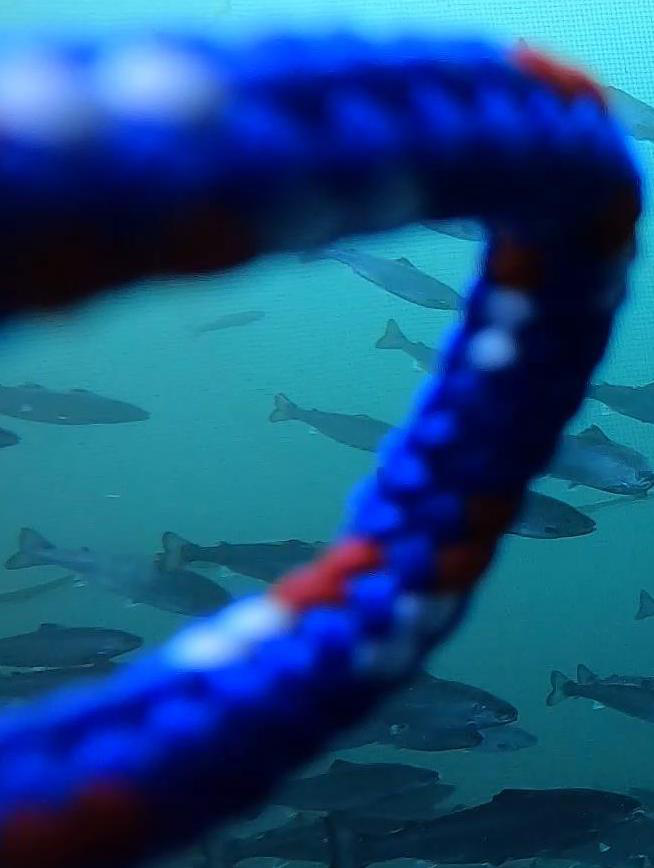

This is counted as a loser fish


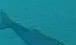

This is counted as a loser fish


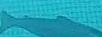

This is counted as a loser fish


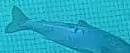

This is counted as a loser fish


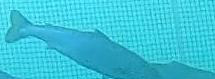

This is counted as a loser fish


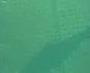

This is counted as a loser fish


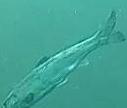

This is counted as a loser fish


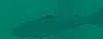

This is counted as a loser fish


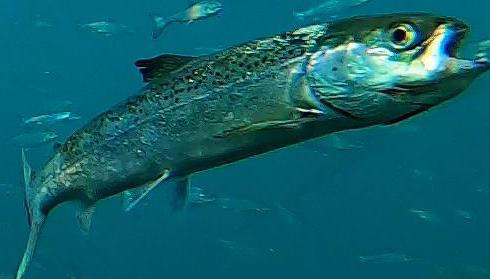

This is counted as a loser fish


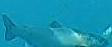

This is counted as a loser fish


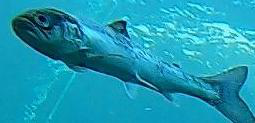

This is counted as a loser fish


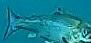

This is counted as a loser fish


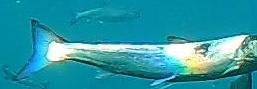

This is counted as a loser fish


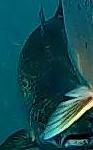

This is counted as a loser fish


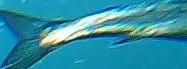

This is counted as a loser fish


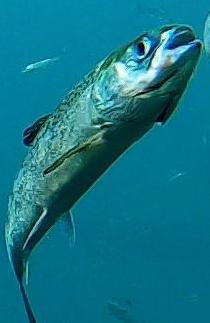

This is counted as a loser fish


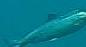

This is counted as a loser fish


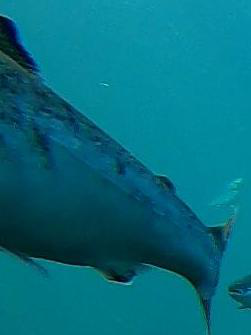

This is counted as a loser fish


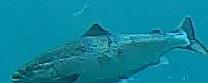

This is counted as a loser fish


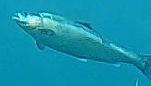

This is counted as a loser fish


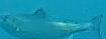

This is counted as a loser fish


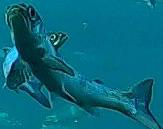

This is counted as a loser fish


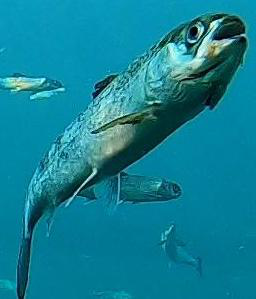

This is counted as a loser fish


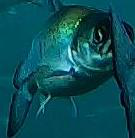

This is counted as a loser fish


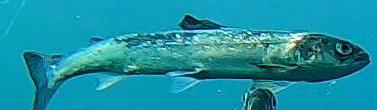

This is counted as a loser fish


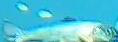

This is counted as a loser fish


This is counted as a loser fish


This is counted as a loser fish


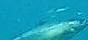

This is counted as a loser fish


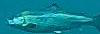

This is counted as a loser fish


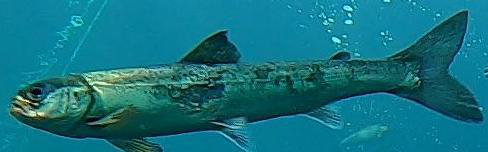

This is counted as a loser fish


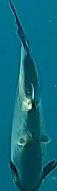

This is counted as a loser fish


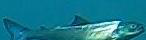

This is counted as a loser fish


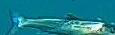

This is counted as a loser fish


This is counted as a loser fish


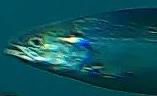

This is counted as a loser fish


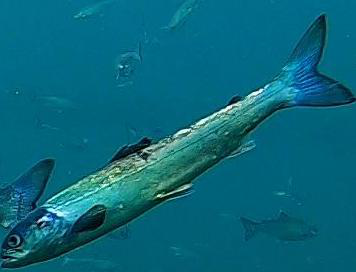

This is counted as a loser fish


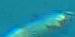

This is counted as a loser fish


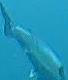

In [ ]:
#display fish counted as loser
result = best_hard_classifier.predict(new_features)
for img, r in zip(image_paths, result):
  if r == 0:
    print("This is counted as a loser fish")
    display(Image.open(img))

#Additional Information

Text(0, 0.5, 'y-coordinates')

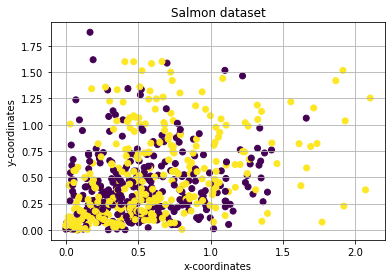

In [ ]:
# Plot the data
plt.figure()

feature_matrix_training = np.array(train_feature_matrix_list) # The list needs to be converted back to an array to plot the data
plt.scatter(feature_matrix_training[:, 0], feature_matrix_training[:, 1], c=train_labels)
plt.title('Salmon dataset')
plt.grid()
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!cat /proc/meminfo

MemTotal:       13297192 kB
MemFree:         7815212 kB
MemAvailable:   10133536 kB
Buffers:          391228 kB
Cached:          2091972 kB
SwapCached:            0 kB
Active:          1050076 kB
Inactive:        4168392 kB
Active(anon):        988 kB
Inactive(anon):  2723736 kB
Active(file):    1049088 kB
Inactive(file):  1444656 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               660 kB
Writeback:             0 kB
AnonPages:       2735232 kB
Mapped:           459036 kB
Shmem:              1292 kB
KReclaimable:     132316 kB
Slab:             165436 kB
SReclaimable:     132316 kB
SUnreclaim:        33120 kB
KernelStack:        5296 kB
PageTables:        42064 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648596 kB
Committed_AS:    4686448 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       10164 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
# Bagging classifier (Bootstrap aggregation)
%%time
estimator_range = [20,40,60,80,100,120,140,160,180,200,220,240,260]

models = []
scores = []
best_estimator = [0, 0]

for n_estimators in estimator_range:

    # Create bagging classifier
    clf = BaggingClassifier(n_estimators = n_estimators, oob_score = True, random_state = 22)

    #voting(clf)

    # Fit the model
    clf.fit(train_feature_matrix_list, train_labels)

    # Append the model and score to their respective list
    models.append(clf)
    score = accuracy_score(y_true = valid_labels, y_pred = clf.predict(valid_feature_matrix_list))
    scores.append(score)

    if score > best_estimator[1]:
      best_estimator[0] = int(n_estimators)
      best_estimator[1] = score

#print(scores)
print(best_estimator)

# Generate the plot of scores against number of estimators
plt.figure(figsize=(9,6))
plt.plot(estimator_range, scores)

# Adjust labels and font (to make visable)
plt.xlabel("n_estimators", fontsize = 18)
plt.ylabel("score", fontsize = 18)
plt.tick_params(labelsize = 16)

# Visualize plot
plt.show()

# Out-of-bag metric
oob_model = BaggingClassifier(n_estimators = best_estimator[0], oob_score = True,random_state = 22)

oob_model.fit(train_feature_matrix_list, train_labels)
print(clf.oob_score_)

------------------------------
Accuracy:           0.922
Precision:          0.928
Recall:             0.744
Best F1 score:      0.826
CPU times: user 1min 59s, sys: 28.9 s, total: 2min 28s
Wall time: 1min 50s


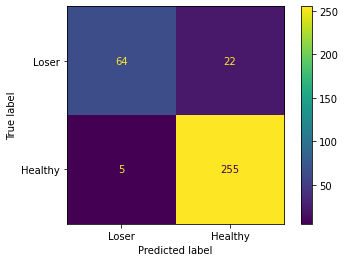

In [ ]:
%%time
# Stacked generalization
estimators = [('percep', percep), ('adaline', adaline), ('svc', svc), ('neighbor', neighbor), ('mlp', mlp)]

final_estimator = GradientBoostingClassifier(n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1, random_state=42)
reg = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

reg.fit(train_feature_matrix_list, train_labels)

voting_predictions = reg.predict(valid_feature_matrix_list)

# Evaluate the models
print('-'*30)
print("Accuracy:          ", accuracy_score(valid_labels, voting_predictions).round(3))
print("Precision:         ", metrics.precision_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))
print("Recall:            ", metrics.recall_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))                                    
print("Best F1 score:     ", metrics.f1_score(valid_labels, voting_predictions, pos_label = positive_label).round(3))         

cm = confusion_matrix(valid_labels, reg.predict(valid_feature_matrix_list)) #cmap=plt.cm.Blues
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loser", "Healthy"])
disp.plot()

[120, 0.8786127167630058]


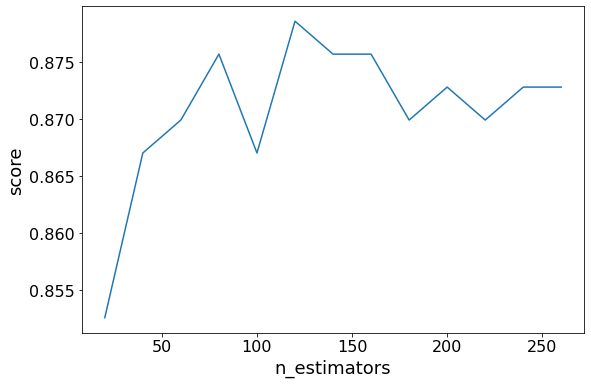

0.8802345058626466
CPU times: user 1h 33min 12s, sys: 4.84 s, total: 1h 33min 17s
Wall time: 1h 33min 51s


In [ ]:
# Bagging classifier (Bootstrap aggregation)
%%time
estimator_range = [20,40,60,80,100,120,140,160,180,200,220,240,260]

models = []
scores = []
best_estimator = [0, 0]

for n_estimators in estimator_range:

    # Create bagging classifier
    clf = BaggingClassifier(n_estimators = n_estimators, oob_score = True, random_state = 22)

    #voting(clf)

    # Fit the model
    clf.fit(train_feature_matrix_list, train_labels)

    # Append the model and score to their respective list
    models.append(clf)
    score = accuracy_score(y_true = valid_labels, y_pred = clf.predict(valid_feature_matrix_list))
    scores.append(score)

    if score > best_estimator[1]:
      best_estimator[0] = int(n_estimators)
      best_estimator[1] = score

#print(scores)
print(best_estimator)

# Generate the plot of scores against number of estimators
plt.figure(figsize=(9,6))
plt.plot(estimator_range, scores)

# Adjust labels and font (to make visable)
plt.xlabel("n_estimators", fontsize = 18)
plt.ylabel("score", fontsize = 18)
plt.tick_params(labelsize = 16)

# Visualize plot
plt.show()

# Out-of-bag metric
oob_model = BaggingClassifier(n_estimators = best_estimator[0], oob_score = True,random_state = 22)

oob_model.fit(train_feature_matrix_list, train_labels)
print(clf.oob_score_)